<a href="https://colab.research.google.com/github/arnaujc91/experiments/blob/main/EmbeddingDropout_training_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai==2.0.16

In [ ]:
from fastai.text.all import *

In [17]:
class EmbeddingDropout(nn.Embedding):
    "Apply dropout with probability `embed_p` to an embedding layer."
    def __init__(self, *args, embed_p, **kwargs):
        super().__init__(*args, **kwargs)
        self.embed_p = embed_p

    def forward(self, words, scale=None):
        if self.training and self.embed_p != 0:
            size = (self.weight.size(0),1)
            mask = dropout_mask(self.weight.data, size, self.embed_p)
            masked_embed = self.weight * mask
        else: masked_embed = self.weight
        if scale: masked_embed.mul_(scale)
        return F.embedding(words, masked_embed, ifnone(self.padding_idx, -1), self.max_norm,
                       self.norm_type, self.scale_grad_by_freq, self.sparse)
        
class AWD_LSTM(Module):
    "AWD-LSTM inspired by https://arxiv.org/abs/1708.02182"
    initrange=0.1

    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False):
        store_attr('emb_sz,n_hid,n_layers,pad_token')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
        # NEW CODE: 
        self.encoder = EmbeddingDropout(vocab_sz, emb_sz, embed_p=embed_p, padding_idx=pad_token)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        # PREVIOUS CODE:
        # self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        # self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        # self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])
        self.reset()

        '''
        IMPORTANT: As you can see previously the layer self.encoder was just used to create the layer self.encoder_dp.
                   Now instead EmbeddingDropout directly inherits from nn.Embedding in order to avoid using self.encoder.
                   Therefore now the code is more compact with the same functionality.
        '''

    def forward(self, inp, from_embeds=False):
        bs,sl = inp.shape[:2] if from_embeds else inp.shape
        if bs!=self.bs: self._change_hidden(bs)

        output = self.input_dp(inp if from_embeds else self.encoder(inp))
        new_hidden = []
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
            output, new_h = rnn(output, self.hidden[l])
            new_hidden.append(new_h)
            if l != self.n_layers - 1: output = hid_dp(output)
        self.hidden = to_detach(new_hidden, cpu=False, gather=False)
        return output

    def _change_hidden(self, bs):
        self.hidden = [self._change_one_hidden(l, bs) for l in range(self.n_layers)]
        self.bs = bs

    def _one_rnn(self, n_in, n_out, bidir, weight_p, l):
        "Return one of the inner rnn"
        rnn = nn.LSTM(n_in, n_out, 1, batch_first=True, bidirectional=bidir)
        return WeightDropout(rnn, weight_p)

    def _one_hidden(self, l):
        "Return one hidden state"
        nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
        return (one_param(self).new_zeros(self.n_dir, self.bs, nh), one_param(self).new_zeros(self.n_dir, self.bs, nh))

    def _change_one_hidden(self, l, bs):
        if self.bs < bs:
            nh = (self.n_hid if l != self.n_layers - 1 else self.emb_sz) // self.n_dir
            return tuple(torch.cat([h, h.new_zeros(self.n_dir, bs-self.bs, nh)], dim=1) for h in self.hidden[l])
        if self.bs > bs: return (self.hidden[l][0][:,:bs].contiguous(), self.hidden[l][1][:,:bs].contiguous())
        return self.hidden[l]

    def reset(self):
        "Reset the hidden states"
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        self.hidden = [self._one_hidden(l) for l in range(self.n_layers)]

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
imdb = pd.read_csv(path/'texts.csv')

In [6]:
imdb_cls  = TextDataLoaders.from_df(imdb, text_col='text', label_col='label')
imdb_lm = TextDataLoaders.from_df(imdb, text_col='text', is_lm=True)

In [35]:
config = {'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 1152,
 'n_layers': 3,
 'out_bias': True,
 'output_p': 0.1,
 'pad_token': 1,
 'tie_weights': True,
 'weight_p': 0.2}; config

{'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 1152,
 'n_layers': 3,
 'out_bias': True,
 'output_p': 0.1,
 'pad_token': 1,
 'tie_weights': True,
 'weight_p': 0.2}

In [36]:
for k in config.keys():
    if k.endswith('_p'): config[k] *= 1.
tie_weights,output_p,out_bias = map(config.pop, ['tie_weights', 'output_p', 'out_bias'])
init = config.pop('init') if 'init' in config else None
encoder = AWD_LSTM(7080, **config)
enc = encoder.encoder if tie_weights else None
decoder = LinearDecoder(7080, config['emb_sz'], output_p, tie_encoder=enc, bias=out_bias)
model = SequentialRNN(encoder, decoder)
# if init is None:
#   mdl = model 
# else: model.apply(init)

In [37]:
url = URLs.WT103_FWD
model_path = untar_data(url , c_key='model')
fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]

In [77]:
fnames

[Path('/root/.fastai/models/wt103-fwd/lstm_fwd.pth'),
 Path('/root/.fastai/models/wt103-fwd/itos_wt103.pkl')]

In [10]:
from fastai.text.learner import _get_text_vocab

In [38]:
old_vocab = load_pickle(fnames[1])
new_vocab = _get_text_vocab(imdb_lm)
wgts = torch.load(fnames[0], map_location = lambda storage,loc: storage)
wgts = match_embeds(wgts, old_vocab, new_vocab)
del wgts['0.encoder_dp.emb.weight']
load_ignore_keys(model, clean_raw_keys(wgts))



<All keys matched successfully>

In [11]:
model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(7080, 400, padding_idx=1)
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=7080, bias=True)
    (output_dp): RNNDropout()
  )
)

In [39]:
def awd_lstm_lm_split(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].rnns, model[0].hidden_dps)]
    groups = L(groups + [nn.Sequential(model[0].encoder, model[1])])
    return groups.map(params)

def requires_grad_bool(m:nn.Module)->Optional[bool]:
    ps = list(m.parameters())
    return ps[0].requires_grad

def trainable_layers(learn):
  modules = [m for m in flatten_model(learn.model) if has_params(m)]
  for it in modules:
    print(f"{requires_grad_bool(it)}  -- ",it)

In [40]:
learn = LMLearner(imdb_lm, model, loss_func=CrossEntropyLossFlat(), splitter=awd_lstm_lm_split, cbs = [ShowGraphCallback])
learn.freeze()

In [41]:
trainable_layers(learn)

True  --  EmbeddingDropout(7080, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 400, batch_first=True)
False  --  ParameterModule()
True  --  Linear(in_features=400, out_features=7080, bias=True)


epoch,train_loss,valid_loss,time
0,4.743114,4.167778,00:15
1,4.593585,4.020850,00:15
2,4.405624,3.937854,00:14
3,4.240870,3.915782,00:14
4,4.119486,3.911188,00:14
5,4.040253,3.908193,00:15
6,3.956089,3.908798,00:15
7,3.910961,3.909264,00:14
8,3.877555,3.908636,00:14
9,3.867923,3.908665,00:14


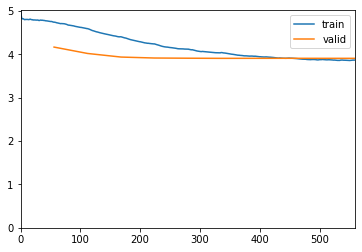

In [42]:
learn.fit_one_cycle(10, 5e-3)

In [43]:
learn.save_encoder('finetuned')

In [44]:
vocab_sz  = 7080

In [45]:
vocab = _get_text_vocab(imdb_cls)
pad_idx, max_len, seq_len= 1, 72*20, 72
n_out = get_c(imdb_cls)
config = awd_lstm_clas_config.copy()
for k in config.keys():
    if k.endswith('_p'): config[k] *= 1.
lin_ftrs = [50]
ps = [0.1]*len(lin_ftrs)
layers = [config['emb_sz'] * 3] + lin_ftrs + [n_out]
ps = [config.pop('output_p')] + ps
init = config.pop('init') if 'init' in config else None
encoder = SentenceEncoder(seq_len, AWD_LSTM(vocab_sz, **config), pad_idx=pad_idx, max_len=max_len)
model = SequentialRNN(encoder, PoolingLinearClassifier(layers, ps, bptt=72))
model if init is None else model.apply(init)

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): EmbeddingDropout(7080, 400, padding_idx=1)
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.4, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine

In [46]:
load_ignore_keys(model[0], clean_raw_keys(wgts))

<All keys matched successfully>

In [74]:
def awd_lstm_clas_split(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [nn.Sequential(model[0].module.encoder)]
    groups += [nn.Sequential(rnn, dp) for rnn, dp in zip(model[0].module.rnns, model[0].module.hidden_dps)]
    groups = L(groups + [model[1]])
    return groups.map(params)

In [75]:
learn = TextLearner(imdb_cls, model, splitter=awd_lstm_clas_split, metrics=[accuracy])
learn.freeze()

In [76]:
learn = learn.load_encoder('finetuned')
learn.freeze()

In [77]:
trainable_layers(learn)

False  --  EmbeddingDropout(7080, 400, padding_idx=1)
False  --  LSTM(400, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 1152, batch_first=True)
False  --  ParameterModule()
False  --  LSTM(1152, 400, batch_first=True)
False  --  ParameterModule()
True  --  BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=1200, out_features=50, bias=False)
True  --  BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
True  --  Linear(in_features=50, out_features=2, bias=False)


In [78]:
learn.fit_one_cycle(12, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.861592,0.674129,0.615000,00:06
1,0.798609,0.591213,0.720000,00:06
2,0.751204,0.518458,0.790000,00:06
3,0.717545,0.488107,0.785000,00:06
4,0.697305,0.471035,0.810000,00:06
5,0.670302,0.445871,0.820000,00:06
6,0.653722,0.444563,0.795000,00:06
7,0.640909,0.438950,0.820000,00:06
8,0.629374,0.431928,0.815000,00:06
9,0.621527,0.426410,0.815000,00:06
